In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

## GRADER PLEASE NOTE

* Some of the instructions are different from the original but still adhere to the rubric.
* The students get the average precipitation per day instead of every single precipitation value.

In [33]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

In [34]:
# Using this date, find the average precipitation per day
# for the preceding 12 months of data sorted by ascending date.
preceding12 = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=366)

In [35]:
#check for most recent date
recent_date

'2017-08-23'

In [42]:
# Convert your results into a pandas DataFrame with date as index.

#query to retrieve the date and precipitation
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= preceding12).all()

#create DataFrame with Datre and Precipitation columns
precipitation_df = pd.DataFrame(query,columns=['Date', 'Precipitation'])

# Change date to datetime object on Pandas
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y-%m-%d')

# Set index to Date
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date',ascending=True)

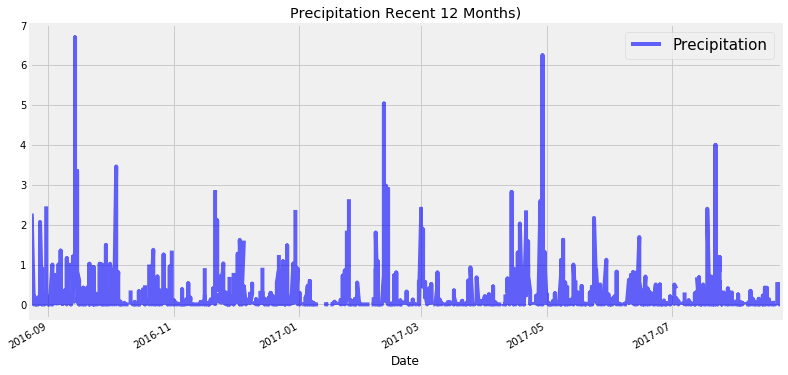

In [61]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation Recent 12 Months)", color='blue', alpha=0.6, figsize=(12,6))
plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel("Date")
plt.savefig("images/Precipitation.png")
plt.show()


In [62]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [66]:
# Query total number of stations in dataset

#query for the count of stations
station_count = session.query(Measurement.station).distinct().count()
print(f"There are {station_count} Stations")

There are 9 Stations


In [81]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#query for the most active station
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

#print out the most active stations
print(f"The most active Stations are")
active_stations

The most active Stations are


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [100]:
# Using the station id from the previous query, calculate the lowest, 
# highest, and average temperature recorded for this station.

#store the most active station
most_active_sta = active_stations[0][0]
#get the temperatures for the most active station
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_sta).all()


#create degree symbol
degree_symbol = '\u00b0'

#print results of Low, High, and Average Temps for the most active station
print(f"The most active Station's Temperatures are:")
print("---------------------------------------------------")
print(f"Low Temp: {most_active_temps[0][0]}{degree_symbol} High Temp: {most_active_temps[0][1]}{degree_symbol} Average Temp: {round(most_active_temps[0][2], 1)}{degree_symbol}")
print("---------------------------------------------------")

The most active Station's Temperatures are:
---------------------------------------------------
Low Temp: 54.0° High Temp: 85.0° Average Temp: 71.7°
---------------------------------------------------


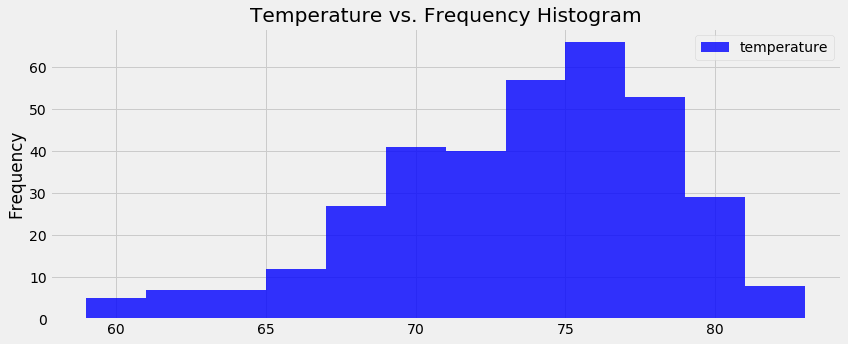

In [107]:
# Query the last 12 months of temperature observation data for this station.
# Plot the results as a histogram with bins = 12.
highest_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
highest_temps_station= highest_temps_station[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query( Measurement.tobs).filter(Measurement.date >= preceding12).filter(Measurement.station == highest_temps_station).all()
temp_observations = pd.DataFrame(temp_observations, columns=['temperature'])
temp_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram",color='blue', alpha=0.8, figsize=(12,5))
plt.tight_layout()
plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()

# Close session